In [ ]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import mpld3

import subprocess
import socket
import time
import os
import gc
import datetime
import logging

import pycuda.driver as cuda

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

In [ ]:
#Finally, import our simulator
from GPUSimulators import Common, LxF, FORCE, HLL, HLL2, KP07, KP07_dimsplit, WAF, IPythonMagic
from GPUSimulators.helpers import InitialConditions

In [ ]:
%setup_logging log_name
%cuda_context_handler cuda_context

Console logger using level INFO
File logger using level DEBUG to output.log
Python version 3.10.15 | packaged by conda-forge | (main, Sep 20 2024, 16:37:05) [GCC 13.3.0]
Registering cuda_context in user workspace
PyCUDA version 2024.1
CUDA version (11, 8, 0)
Driver version 12040
Using device 0/1 'Quadro GV100' (0000:01:00.0) GPU
Created context handle <98925023734272>
Using CUDA cache dir /home/aadi.bhure/Code-pk/FiniteVolumeGPU/GPUSimulators/cuda_cache
Autotuning enabled. It may take several minutes to run the code the first time: have patience


In [ ]:
def downsample(highres_solution, factor):
    if (len(highres_solution.shape) == 1):
        highres_solution = highres_solution.reshape((1, highres_solution.size))

    assert(highres_solution.shape[1] % factor == 0)
    ny = highres_solution.shape[0] 
    nx = highres_solution.shape[1] / factor

    if (factor == 1):
        return highres_solution
    else:
        
        return highres_solution.reshape([int(ny), int(1), int(nx), int(factor)]).mean(3).mean(1)

In [ ]:
def wall_boundary_conditions(data, num_ghost_cells):
    data[0:num_ghost_cells,:] = data[2*num_ghost_cells-1:num_ghost_cells-1:-1,:]
    data[-num_ghost_cells:,:] = data[-num_ghost_cells-1:-2*num_ghost_cells-1:-1,:]
    data[:,0:num_ghost_cells] = data[:,2*num_ghost_cells-1:num_ghost_cells-1:-1]
    data[:,-num_ghost_cells:] = data[:,-num_ghost_cells-1:-2*num_ghost_cells-1:-1]
    return data

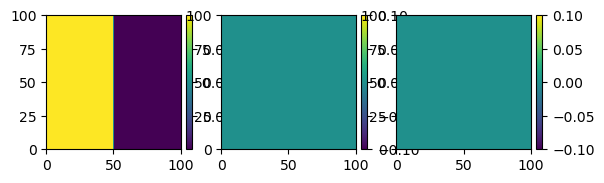

In [ ]:
# Initial conditions
width = 10.0
def gen_test_data(nx, ref_nx, g, num_ghost_cells):
    assert(num_ghost_cells >= 1)
    ref_ny = num_ghost_cells
    ny = ref_ny
    
    dx = width / float(nx)
    dy = 1.0

    h_highres = np.zeros((ref_ny, ref_nx))
    h = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);

    #Create dam break
    x = np.linspace(0, width, ref_nx)
    
    h_highres = np.where(x < 5, 0.005, 0.001);    
    h[num_ghost_cells:-num_ghost_cells, num_ghost_cells:-num_ghost_cells] = downsample(h_highres, ref_nx/nx)
    h = wall_boundary_conditions(h, num_ghost_cells);
    
    max_h_estimate = 0.005
    max_u_estimate = 0.3
    dt = min(dx, dy) / (max_u_estimate + np.sqrt(g*max_h_estimate))
    
    return h, hu, hv, dx, dy, dt


h, hu, hv, dx, dy, dt = gen_test_data(nx=100, ref_nx=1000, g=9.81, num_ghost_cells=2)

plt.figure()
ax=plt.subplot(1,3,1)
im=plt.imshow(h, extent=[0, 100, 0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax=plt.subplot(1,3,2)
im=plt.imshow(hu, extent=[0, 100, 0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax=plt.subplot(1,3,3)
im=plt.imshow(hv, extent=[0, 100, 0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ic = "shock1d"
plt.show()

In [ ]:
ic = "shock1d"
def gen_filename(simulator, nx):
    return os.path.abspath(os.path.join("data", "shock1d", str(simulator.__name__) + "_" + str(nx) + ".npz"))

In [ ]:
def sanity_check(variable, variable_name):
    maxval = np.amax(variable)
    minval = np.amin(variable)
    assert np.isnan(maxval) == False and np.isnan(minval) == False, variable_name + " contains NaN values"

def run_benchmark(datafilename, simulator, courant_number, nx, ref_nx, ghost_cells, tf=6.0, max_nt=np.inf, g=9.81, force_rerun=False, transpose=False):
    if (datafilename and os.path.isfile(datafilename) and force_rerun == False):
        print("WARNING: Existing simulation exists, skipping simulation")
        return [0, 0, 0]
    else:
        h0, hu0, hv0, dx, dy, dt = gen_test_data(nx, ref_nx, g, ghost_cells)
        ny = ghost_cells
        dt = dt * courant_number

        #Initialize simulator
        with Common.Timer(simulator.__name__ + "_" + str(nx)) as timer:
            if (transpose):
                h0 = np.ascontiguousarray(np.transpose(h0))
                hu0, hv0 = np.ascontiguousarray(np.transpose(hv0)), np.ascontiguousarray(np.transpose(hu0))
                dx, dy = dy, dx
                nx, ny = ny, nx
                
            sim_args = {'context': cuda_context, 
                            'h0': h0, 'hu0': hu0, 'hv0': hv0, 
                            'nx': nx, 'ny': ny, 
                            'dx': dx, 'dy': dy, 
                            'dt': None, 
                            'g' : g}
            sim = simulator(**sim_args)
            t, nt, elapsed_time = sim.simulate(tf, max_nt)
            sim.check()

            nt = sim.simSteps()
            t = sim.simTime()
            dt = sim.simTime() / nt
            h, hu, hv = sim.download()

            if (transpose):
                h = np.transpose(h)
                hu, hv = np.ascontiguousarray(np.transpose(hv)), np.ascontiguousarray(np.transpose(hu))

            sanity_check(h, "h")
            sanity_check(hu, "hu")
            sanity_check(hv, "hv")

            if (datafilename):
                dirname = os.path.dirname(datafilename)
                if (dirname and not os.path.isdir(dirname)):
                    os.makedirs(dirname)
                np.savez_compressed(datafilename, h=h, hu=hu, hv=hv)
        
    gc.collect() # Force run garbage collection to free up memory
    
    return [t, nt, elapsed_time]

## Run simulations 

In [ ]:
logger = logging.getLogger(__name__)
sim_args = {
    'context': cuda_context,
    'cfl_scale': 0.9,
    'g': 9.81
}
g = 9.81
H_REF = 0.5
H_AMP = 0.1
U_REF = 0.0
U_AMP = 0.1
force_rerun = True
transpose = False

# Reference solution computed by just running simulators on finer meshes
ref_nx = 8192 * 4
# Must be factors of `ref_nx` for downsampling to work
domain_sizes = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
simulators = [LxF.LxF, HLL.HLL, HLL2.HLL2, KP07.KP07, KP07_dimsplit.KP07_dimsplit, WAF.WAF]
simulator_reference = [LxF.LxF, HLL.HLL, HLL2.HLL2, KP07.KP07, KP07_dimsplit.KP07_dimsplit, WAF.WAF]
simulator_ghost_cells = [1, 1, 2, 2, 2, 2]
simulator_courant_numbers = [0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95]

### Simulation for spatial data

In [ ]:
# Make space to store
sim_elapsed_time = np.zeros((len(simulators), len(domain_sizes)))
sim_dt = np.zeros_like(sim_elapsed_time)
sim_nt = np.zeros_like(sim_elapsed_time)

# TODO FIXME warmup!

for i in range(len(simulators)):
    # Run reference with a low CFL-number. TODO IT DOES NOT!
    # This should also serve as warmup for now? TODO
    datafilename = gen_filename(simulators[i], ref_nx)
    _, _, secs = run_benchmark(datafilename, 
                          simulator_reference[i],
                          simulator_courant_numbers[i] * 0.5,
                          ref_nx, ref_nx,
                          simulator_ghost_cells[i],
                          tf = 6.0, max_nt = np.inf,
                          #dt=0.25*0.7*(width/ref_nx)/(u_ref+u_amp + np.sqrt(g*(h_ref+h_amp))),
                          force_rerun=force_rerun,
                          transpose=transpose)
    logger.info(f"{simulators[i].__name__} completed reference simulation in {secs}s.")

    # Run on all the sizes
    for j, nx in enumerate(domain_sizes):
        datafilename = gen_filename(simulators[i], nx)
        t, nt, secs = run_benchmark(datafilename, 
                          simulators[i],
                          simulator_courant_numbers[i],
                          nx, ref_nx,
                          simulator_ghost_cells[i],
                          tf = 6.0, max_nt = np.inf,
                          #dt=0.25*0.7*(width/ref_nx)/(u_ref+u_amp + np.sqrt(g*(h_ref+h_amp))),
                          force_rerun=force_rerun,
                          transpose=transpose)
        logger.info(f"{simulators[i].__name__} completed {nx}-celled simulation in {secs}s.")

        # store
        sim_elapsed_time[i, j] = secs
        sim_nt[i, j] = nt
        sim_dt[i, j] = t / nt

    # _ to prevent output being printed to the screen
    _ = gc.collect()

### Simulations for temporal data

In [ ]:
MAX_NT = 10000 # for now
# Make space to store
longsim_elapsed_time = np.zeros((len(simulators), len(domain_sizes)))
longsim_dt = np.zeros_like(longsim_elapsed_time)
longsim_tf = np.zeros_like(longsim_elapsed_time)

# TODO FIXME warmup!

for i in range(len(simulators)):
    # Run on all the sizes
    for j, nx in enumerate(domain_sizes):
        t, nt, secs = run_benchmark(None,
                          simulators[i],
                          simulator_courant_numbers[i],
                          nx, ref_nx,
                          simulator_ghost_cells[i],
                          tf = np.inf, max_nt = MAX_NT,
                          #dt=0.25*0.7*(width/ref_nx)/(u_ref+u_amp + np.sqrt(g*(h_ref+h_amp))),
                          force_rerun=force_rerun,
                          transpose=transpose)
        logger.info(f"{simulators[i].__name__} simulated {nt} steps in {secs}s.")

        # store
        longsim_elapsed_time[i, j] = secs
        longsim_dt[i, j] = t / nt
        longsim_tf[i,j] = t

# _ to prevent output being printed to the screen
_ = gc.collect()

## Timey-wimey<adjective> calculation

In [ ]:
ds = np.array(domain_sizes)
secs_per_timestep = longsim_elapsed_time / MAX_NT
# domain is 2 cells wide in the y-direction
megacells_per_sec = ds * 2 * 10**-6 * MAX_NT / longsim_elapsed_time

## Error calculation

In [ ]:
# Constants for calculating norms
ref_dx = width / ref_nx
dxs = width / np.array(domain_sizes)
sim_errors = np.zeros_like(sim_elapsed_time)
sim_cons = np.zeros_like(sim_elapsed_time)
sim_errors_u = np.zeros_like(sim_errors)

for i, simulator in enumerate(simulators):
    datafilename = gen_filename(simulator, ref_nx) 
    with np.load(datafilename) as data:
        h_ref = data['h'].astype(np.float128)

    for j, nx in enumerate(domain_sizes):
        datafilename = gen_filename(simulator, nx)
        with np.load(datafilename) as data:
            h = data['h'].astype(np.float128)

        # downsample
        h_ref_downsampled = InitialConditions.downsample(h_ref, ref_nx / nx, 1)

        # error calculation
        dx = np.array(dxs[j]).astype(np.float128)
        error_d = np.linalg.norm((h_ref_downsampled - h).flatten(), ord = 1) * dx
        sim_errors[i, j] = error_d

        conservation = (np.sum(h_ref) * ref_dx - np.sum(h) * dx)
        sim_cons[i, j] = conservation

# Plots!

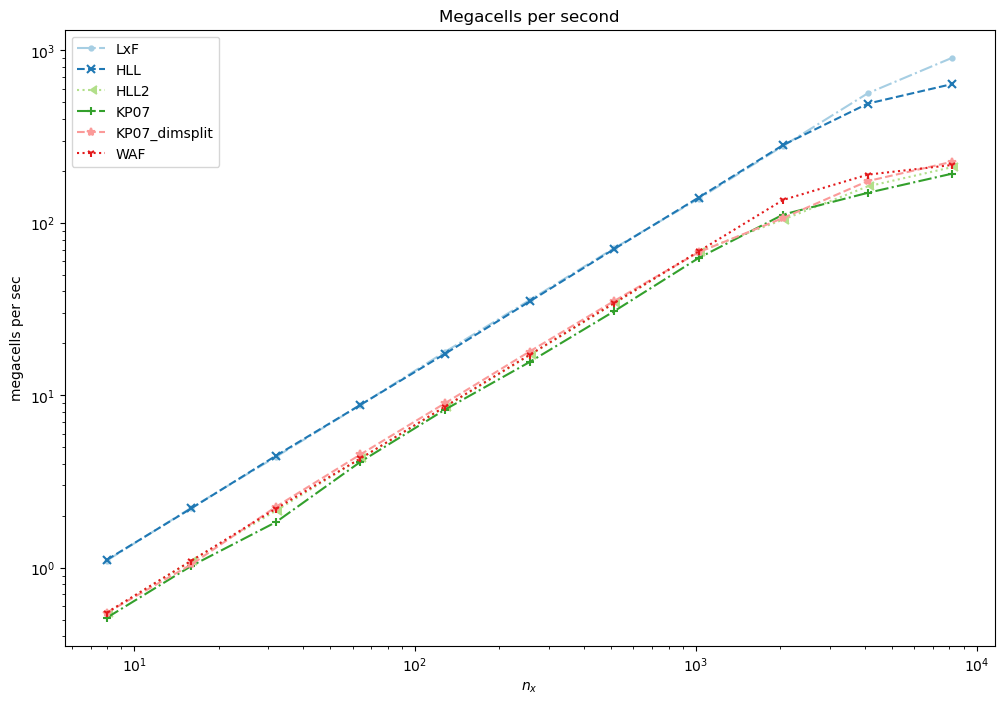

In [ ]:
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()

miscPlotting.setBwStyles(fig.gca())
for i, simulator in enumerate(simulators):
    plt.loglog(ds, megacells_per_sec[i,:], label = simulator.__name__)
    plt.xlabel("$n_x$")
    plt.ylabel("megacells per sec")
plt.legend()
plt.title("Megacells per second")
miscPlotting.save_figure(fig, "megacells per second")

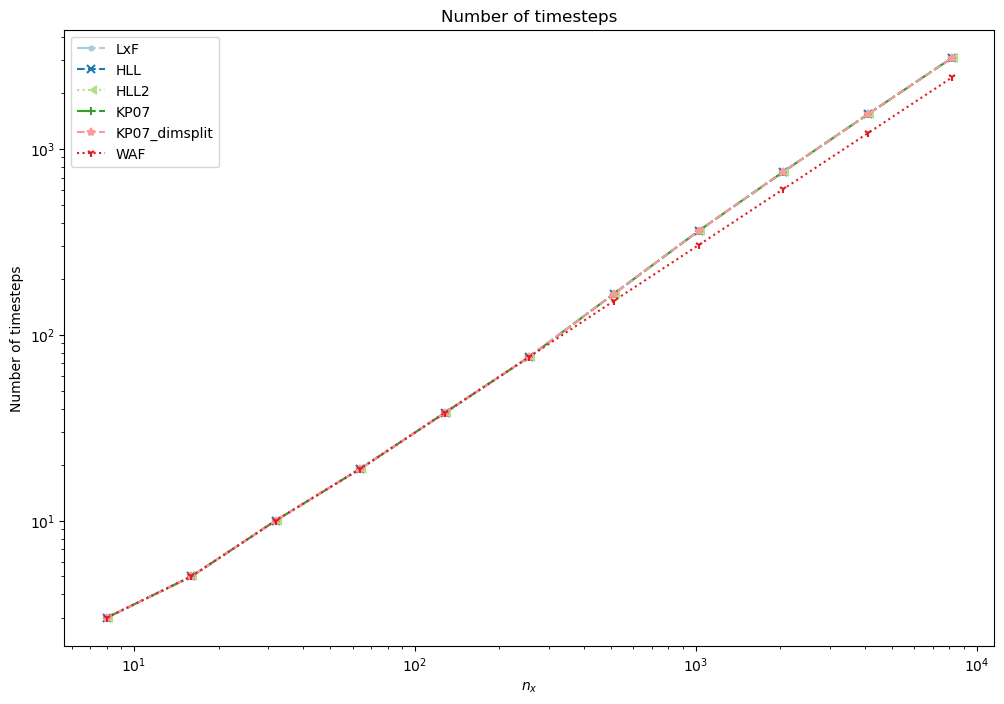

In [ ]:
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()

miscPlotting.setBwStyles(fig.gca())
for i, simulator in enumerate(simulators):
    plt.loglog(ds, sim_nt[i,:], label = simulator.__name__)
    plt.xlabel("$n_x$")
    plt.ylabel("Number of timesteps")
plt.legend()
plt.title("Number of timesteps")
miscPlotting.save_figure(fig, "number_of_timesteps", ic)

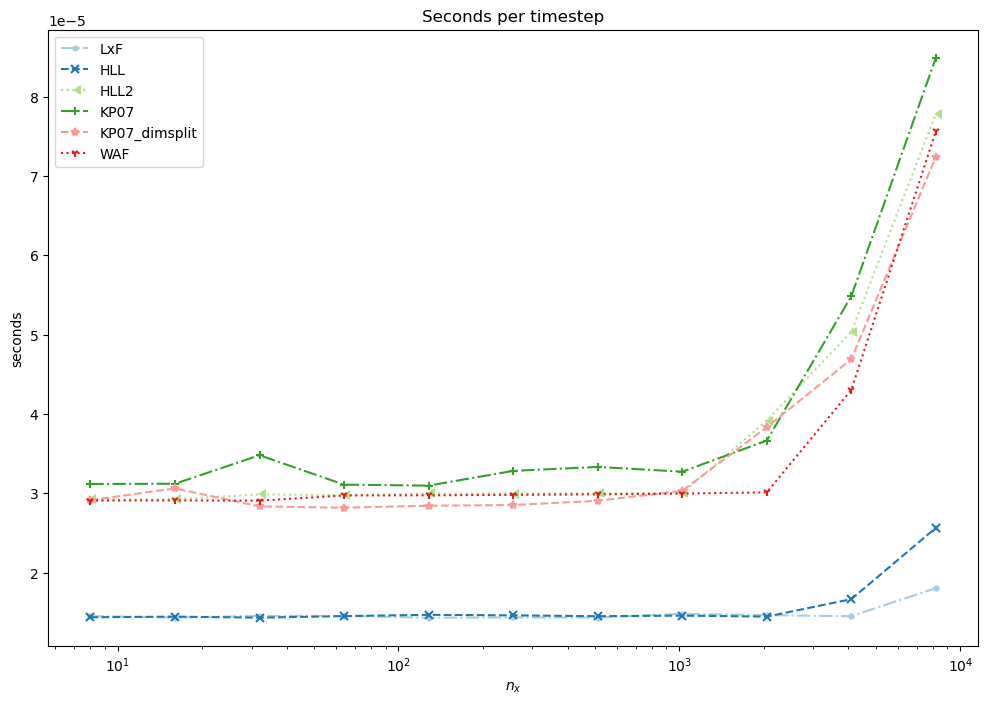

In [ ]:
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()

miscPlotting.setBwStyles(fig.gca())
for i, simulator in enumerate(simulators):
    plt.semilogx(ds, secs_per_timestep[i,:], label = simulator.__name__)
    plt.xlabel("$n_x$")
    plt.ylabel("seconds")
plt.legend()
plt.title("Seconds per timestep")
miscPlotting.save_figure(fig, "seconds_per_timestep", ic)

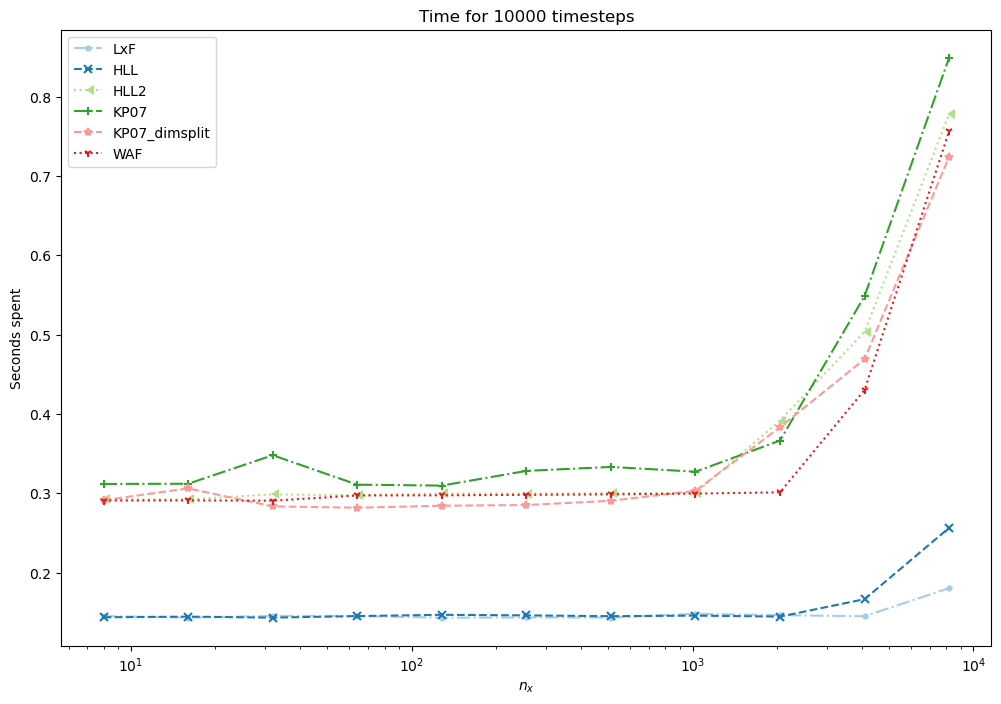

In [ ]:
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()

miscPlotting.setBwStyles(fig.gca())
for i, simulator in enumerate(simulators):
    plt.semilogx(ds, longsim_elapsed_time[i,:], label = simulator.__name__)
    plt.xlabel("$n_x$")
    plt.ylabel("Seconds spent")
plt.legend()
plt.title(f"Time for {MAX_NT} timesteps")
miscPlotting.save_figure(fig, "longtime_spent", ic)

## Convergence rate plot

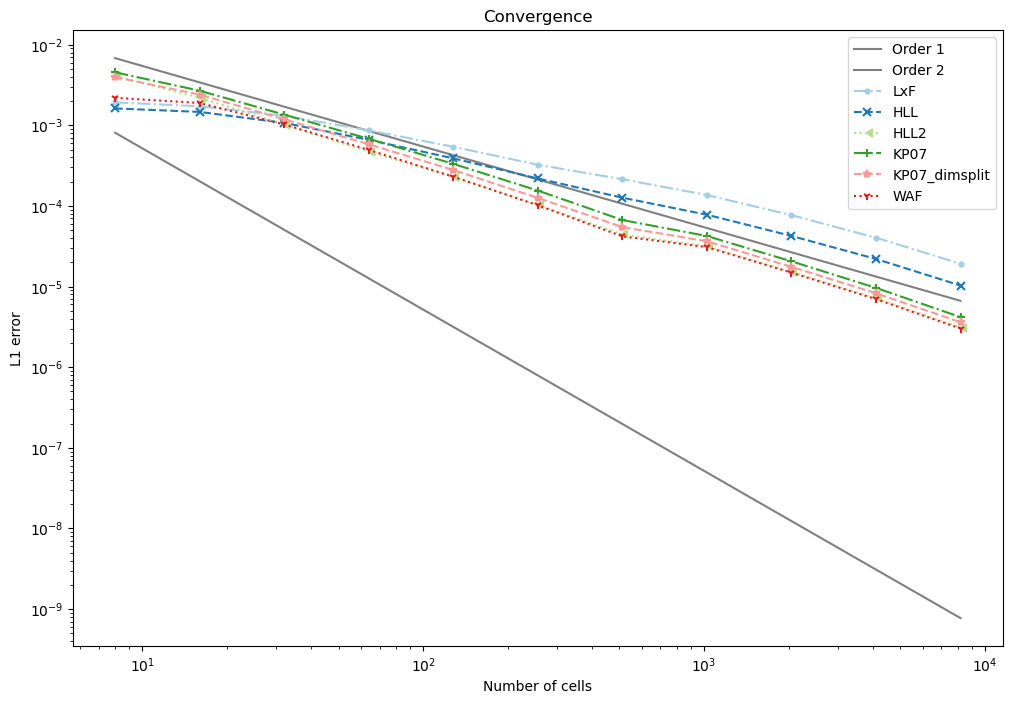

In [ ]:
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()
scaling = np.max(sim_errors[:,0]) * 1.5 * domain_sizes[0]
plt.plot(domain_sizes, scaling / np.array(domain_sizes), '-', c='gray', label='Order 1')
scaling = np.min(sim_errors[:,0]) * 0.5 * domain_sizes[0] ** 2
plt.plot(domain_sizes, scaling / np.power(domain_sizes, 2), '-', c='gray', label='Order 2')

miscPlotting.setBwStyles(fig.gca())
for i, simulator in enumerate(simulators):
    plt.loglog(domain_sizes, sim_errors[i,:], label = simulator.__name__)
    plt.xlabel("Number of cells")
    plt.ylabel("L1 error")
plt.legend()
plt.title("Convergence")
miscPlotting.save_figure(fig, "convergence_rate_all", ic)

## Time vs absolute error plot

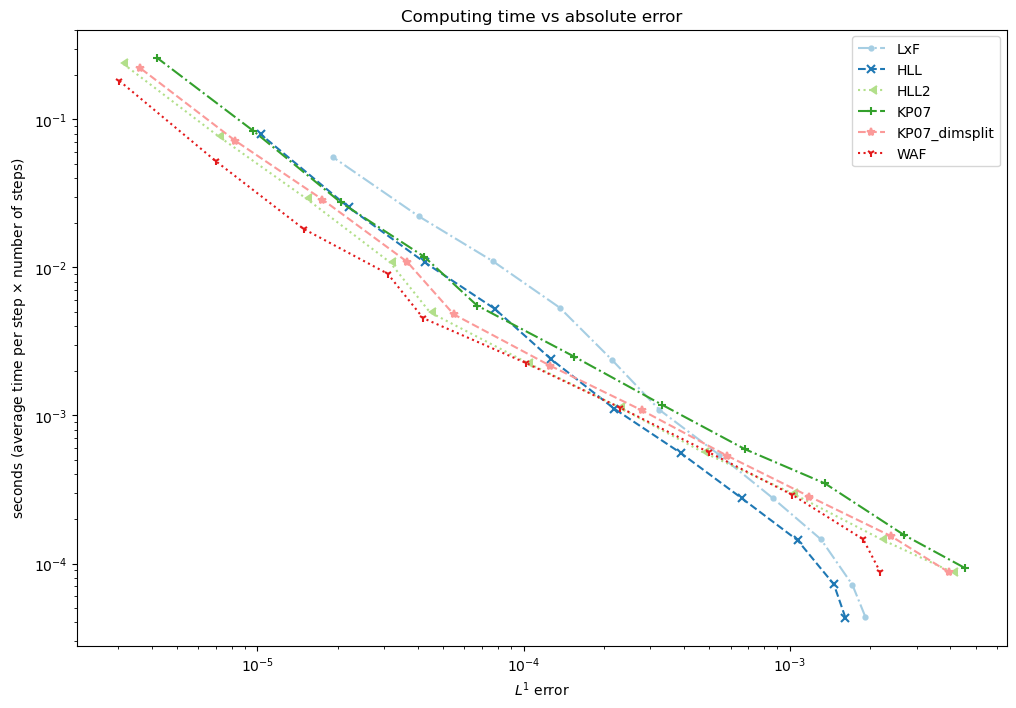

In [ ]:
# Plot the timing and error data
import miscPlotting
import importlib
importlib.reload(miscPlotting)
fig = plt.figure()
miscPlotting.setBwStyles(fig.gca())
plt.title("Computing time vs absolute error")

for i, simulator in enumerate(simulators):
    plt.loglog(sim_errors[i,:], secs_per_timestep[i,:] * sim_nt[i,:], label = simulator.__name__)
    plt.xlabel("$L^1$ error")
    plt.ylabel("seconds (average time per step $\\times$ number of steps)")

plt.legend()
miscPlotting.save_figure(fig, "time_to_solution", ic)

## Solution plots

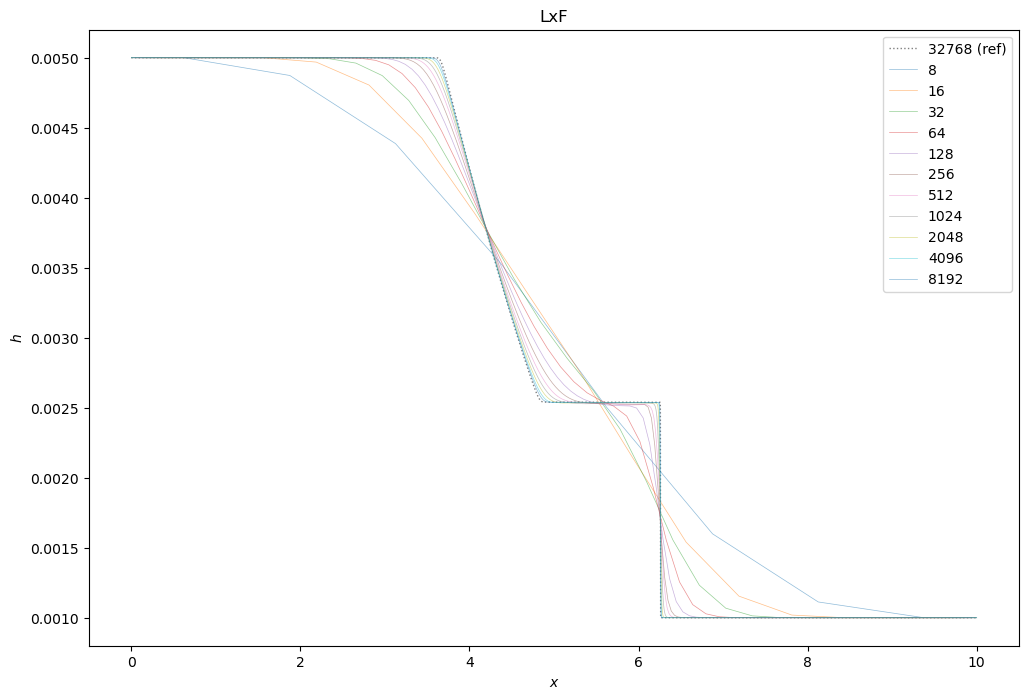

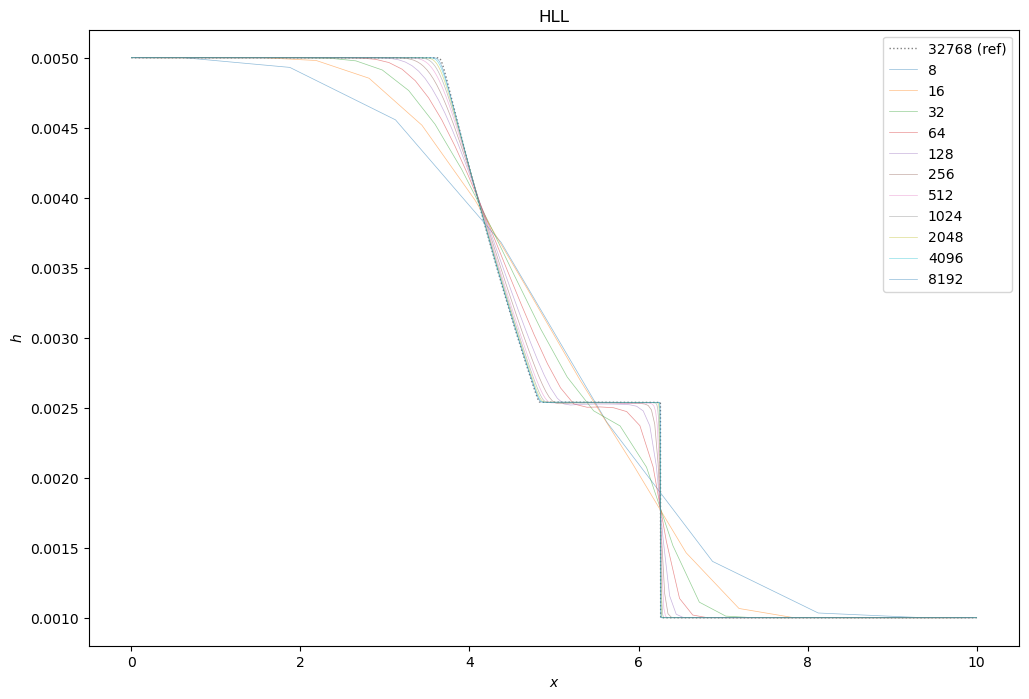

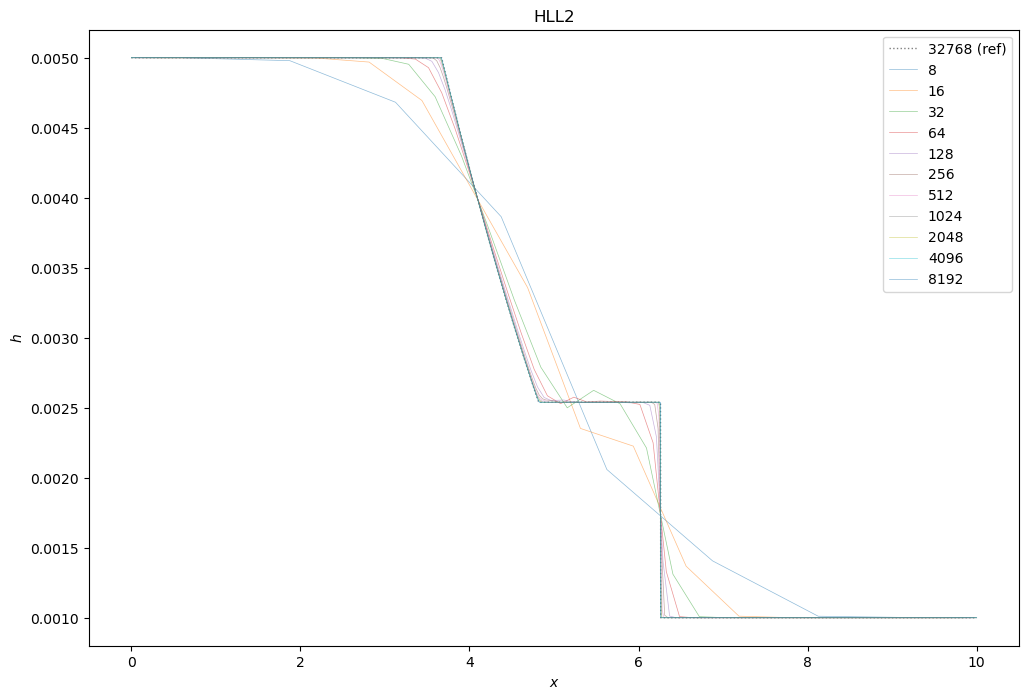

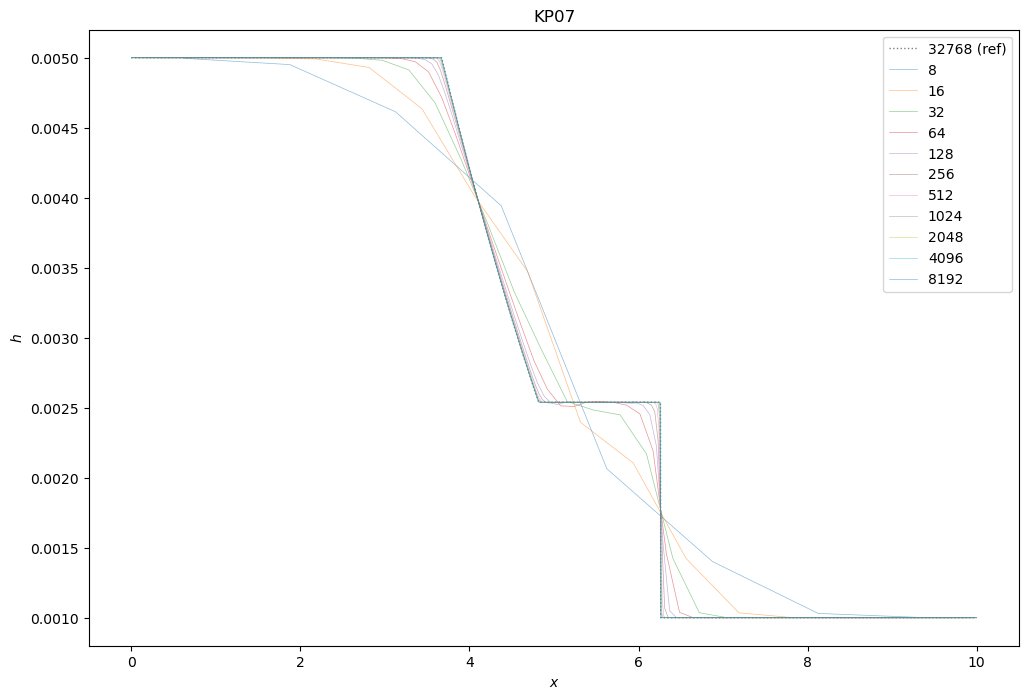

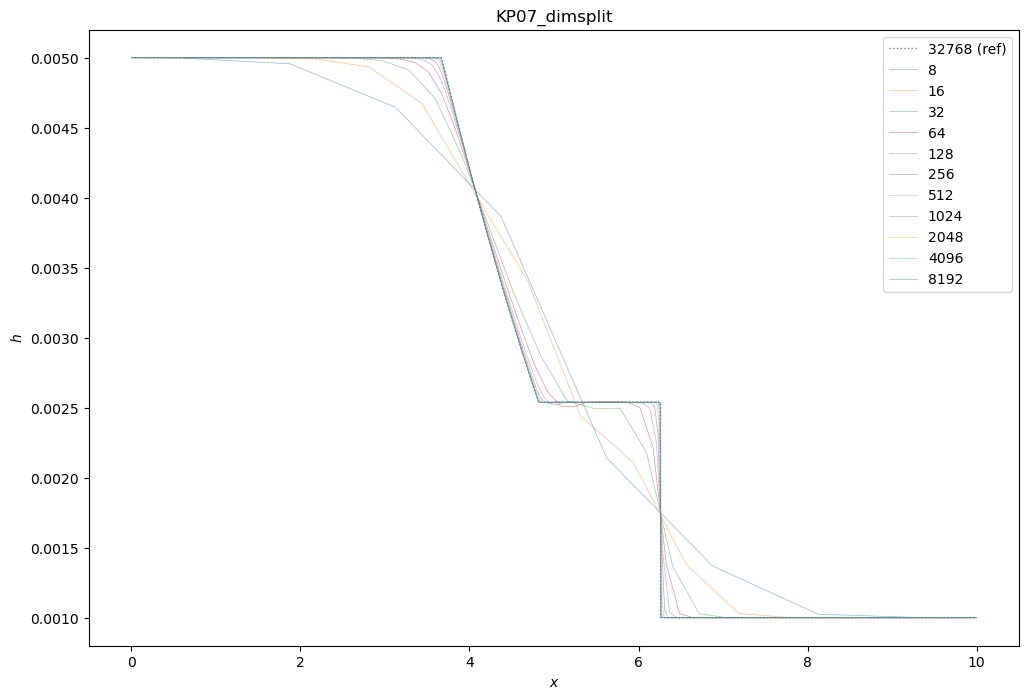

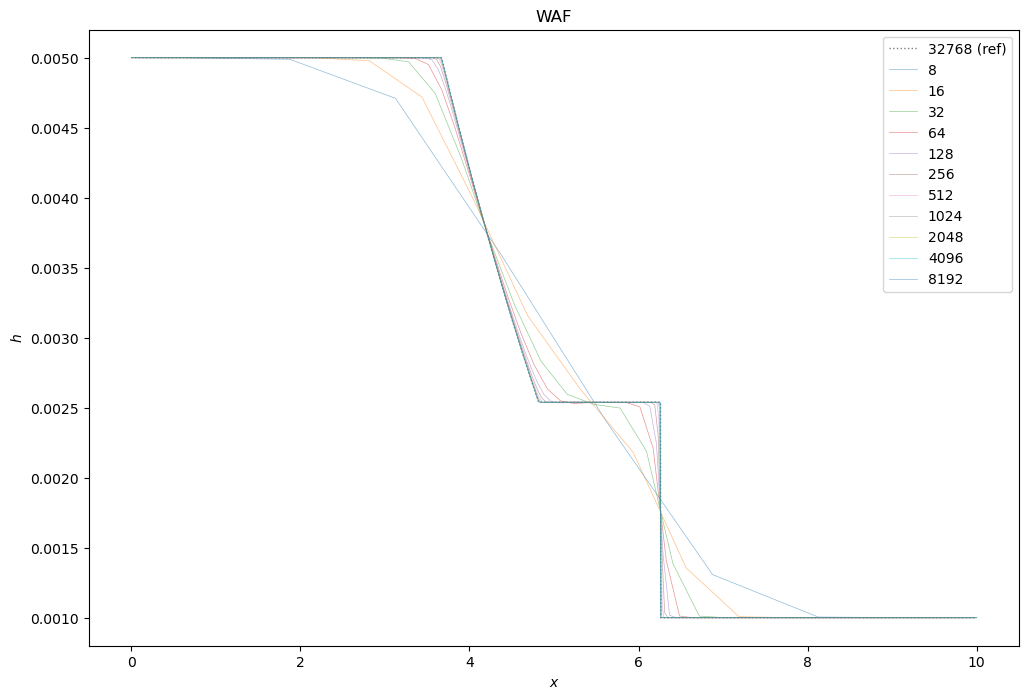

In [ ]:
def plot_solution(simulator, nx, label, **kwargs):
    datafilename = gen_filename(simulator, nx)
    
    #Read the solution
    with np.load(datafilename) as data:
        h = data['h']
        
    x = np.linspace(0.5, nx-0.5, nx)*10.0/float(nx)
    y = h[0,:]
    
    plt.plot(x, y, label=label, **kwargs)
    
    h = None
    x = None
    gc.collect() # Force 

for i, simulator in enumerate(simulators):
    fig = plt.figure()
    # miscPlotting.setBwStyles(fig.gca())
    plot_solution(simulator, ref_nx, label=str(ref_nx) +" (ref)", c='k', ls='dotted', marker=None, lw=1, alpha=0.5)
    for j, nx in enumerate(domain_sizes):
#        fig.set_prop_cycle(cycler('color', miscPlotting.sns.color_palette()))
        plot_solution(simulator, nx, label=str(nx), marker=None, lw=0.5, alpha=0.5)
    plt.xlabel("$x$")
    plt.ylabel("$h$")
    plt.legend()
    plt.title(simulator.__name__)
#    miscPlotting.save_figure(fig, f" solution_{simulator.__name__}", ic)